<a href="https://colab.research.google.com/github/a-smaruj/Machine-learning-finance-classes/blob/main/Use_case_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163009 sha256=64e00c3f62e43c195949f8f9be562a0cc91e92f836340ae35233f68bad41a201
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import re
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBaseline
from surprise import Dataset
from surprise import Reader

## Load data

In [3]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

## Explore data

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
print('Liczba ocen:', len(ratings))
print('Liczba filmów:', len(movies))
print('Liczba użytkowników:', len(pd.unique(ratings['userId'])))
print('Średnią liczba ocen na użytkownika:', round(mean(ratings.groupby(['userId']).count()['rating']), 2))
print('Średnią liczba ocen na film:', round(mean(ratings.groupby(['movieId']).count()['rating']), 2))

Liczba ocen: 100836
Liczba filmów: 9742
Liczba użytkowników: 610
Średnią liczba ocen na użytkownika: 165.3
Średnią liczba ocen na film: 10.37


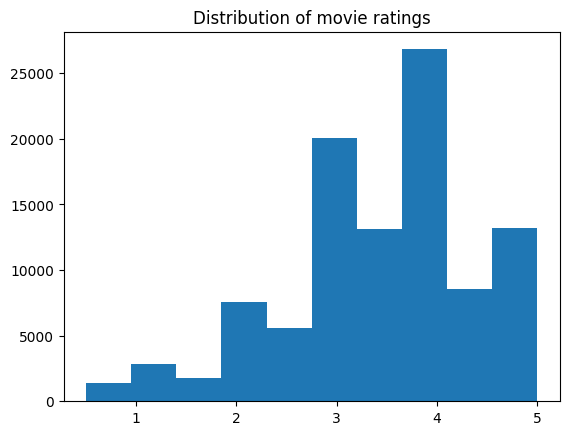

In [7]:
plt.hist(ratings['rating'])
plt.title('Distribution of movie ratings')
plt.show()

## Prepare data


In [8]:
def split_genre(x):
  return x.split("|")

movies['genres'] = movies['genres'].apply(split_genre)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [9]:
def take_year(x):
  y = re.findall("\((\d{4})\)", x)
  if y == []:
    return np.nan
  else:
    return y[0]

movies['year'] = movies['title'].apply(take_year)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


## Dict

In [10]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

## Def

In [11]:
def name_to_id(movie_title):
  return [k for k, v in movie_titles.items() if movie_title in v][0]

## Bayesian Average

In [12]:
movie_stats = ratings.groupby(['movieId'])[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [13]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats.describe()

,movieId,count,mean,bayesian_avg
count,9724.000000,9724.000000,9724.000000,9724.000000
mean,42245.024373,10.369807,3.262448,3.285871
std,52191.137320,22.401005,0.869874,0.227598
min,1.000000,1.000000,0.500000,2.190377
25%,3245.500000,1.000000,2.800000,3.151413
50%,7300.000000,3.000000,3.416667,3.283341
75%,76739.250000,9.000000,3.911765,3.390547
max,193609.000000,329.000000,5.000000,4.392070


## Recommendation system - sparse matrix and knn

### Sparse matrix

In [14]:
def create_sparse(df):
  M = df['userId'].nunique()
  N = df['movieId'].nunique()

  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]

  X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))

  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [15]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)

In [16]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
sparsity_p = round(sparsity*100,2)
print(f"Matrix sparsity: {sparsity_p}%")

n_ratings_per_user = X.getnnz(axis=1)

Matrix sparsity: 1.7%


### kNN

In [17]:
def find_similar_movies_knn(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
  X = X.T
  neighbour_ids = []
  movie_ind = movie_mapper[movie_id]
  movie_vec = X[movie_ind]
  if isinstance(movie_vec, (np.ndarray)):
    movie_vec = movie_vec.reshape(1,-1)
  kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
  kNN.fit(X)
  neighbour = kNN.kneighbors(movie_vec, return_distance=False)
  for i in range(0,k):
    n = neighbour.item(i)
    neighbour_ids.append(movie_inv_mapper[n])
  neighbour_ids.pop(0)

  neighbour_title = [movie_titles[n_id] for n_id in neighbour_ids]

  return neighbour_title

In [18]:
recomends = find_similar_movies_knn(name_to_id('Toy Story'), X, movie_mapper, movie_inv_mapper, 10)
recomends

['Toy Story 2 (1999)',
 'Jurassic Park (1993)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Forrest Gump (1994)',
 'Lion King, The (1994)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Mission: Impossible (1996)',
 'Groundhog Day (1993)']

## Exercises

Podaj liczbę filmów Sci-Fi

In [43]:
print("Liczba filmów Sci-Fi:", movies['genres'].apply(lambda x: 'Sci-Fi' in x).sum())

Liczba filmów Sci-Fi: 980


Pokaż rozkład ocen komedii z 2017

In [20]:
comedy_2017 = movies[(movies['genres'].apply(lambda x: 'Comedy' in x)) & (movies['year'] == '2017')]
comedy_2017.head()

,movieId,title,genres,year
9446,167380,A Dog's Purpose (2017),"[Comedy, Drama]",2017
9449,167634,Fist Fight (2017),[Comedy],2017
9452,167746,The Lego Batman Movie (2017),"[Action, Animation, Comedy]",2017
9459,168174,Jim Gaffigan: Cinco (2017),[Comedy],2017
9466,168326,The Big Sick (2017),"[Comedy, Romance]",2017


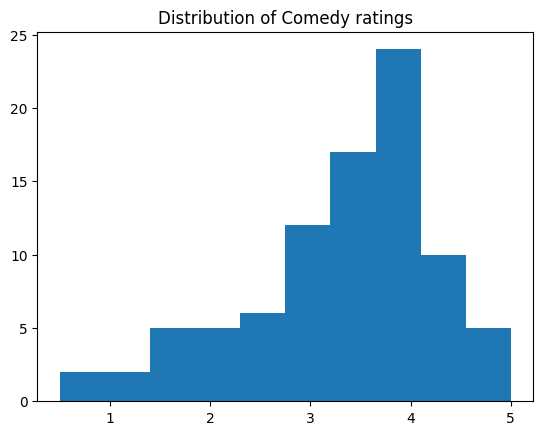

In [21]:
rating_comedy_2017 = ratings[ratings['movieId'].isin(comedy_2017['movieId'])]
plt.hist(rating_comedy_2017['rating'])
plt.title('Distribution of Comedy ratings')
plt.show()

Podaj średnią ocen wszystkich filmów akcji

In [22]:
action = movies[(movies['genres'].apply(lambda x: 'Action' in x))]
rating_action = ratings[ratings['movieId'].isin(action['movieId'])]
print('Średnią ocen wszystkich filmów akcji:', round(mean(rating_action['rating']), 2))

Średnią ocen wszystkich filmów akcji: 3.45


Podaj 3 filmy akcji najczęściej oceniane

In [23]:
action_counts = rating_action['movieId'].value_counts()
for id in action_counts.head(3):
  print(movie_titles[id])

Miami Rhapsody (1995)
Hunted, The (1995)
Far From Home: The Adventures of Yellow Dog (1995)


## Recommendation system - surprise

In [24]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

### Zbuduj system na podstawie algorytmu SVD

In [25]:
def recommendation_system_svd(movie_id, trainset, n=10):

  model_svd = SVD(random_state=42)
  model_svd.fit(trainset)

  movie_ind = model_svd.trainset.to_inner_iid(movie_id)
  movie_vec = model_svd.qi[movie_ind]

  similarity_scores = pd.DataFrame(model_svd.qi).dot(movie_vec)
  similar = similarity_scores.sort_values(ascending=False).index.tolist()

  similar_ids = [model_svd.trainset.to_raw_iid(i) for i in similar[1:n+1]]
  similar_title = [movie_titles[n_id] for n_id in similar_ids]

  return similar_title

In [26]:
recommendation_system_svd(name_to_id('Toy Story'), trainset)

['Aladdin (1992)',
 'Babe (1995)',
 'Toy Story 2 (1999)',
 'American Pie (1999)',
 'Backdraft (1991)',
 'E.T. the Extra-Terrestrial (1982)',
 'Fantasia (1940)',
 'Back to the Future (1985)',
 "Let's Go to Prison (2006)",
 "It's a Wonderful Life (1946)"]

### Zbuduj system na podstawie algorytmu kNN Baseline

In [27]:
def recommendation_system_knn(movie_id, trainset, k=10, n=10):

  model_kNN = KNNBaseline(k=k, sim_options={'name': 'pearson_baseline', 'user_based': False})
  model_kNN.fit(trainset)

  movie_ind = model_kNN.trainset.to_inner_iid(movie_id)
  neighbour = model_kNN.get_neighbors(movie_ind, k=n)

  neighbour_ids = [model_kNN.trainset.to_raw_iid(i) for i in neighbour]
  neighbour_title = [movie_titles[n_id] for n_id in neighbour_ids]

  return neighbour_title

In [28]:
recommendation_system_knn(name_to_id('Toy Story'), trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


['Toy Story 2 (1999)',
 'Aladdin (1992)',
 'Incredibles, The (2004)',
 'Finding Nemo (2003)',
 'Back to the Future (1985)',
 'Toy Story 3 (2010)',
 'Babe (1995)',
 'E.T. the Extra-Terrestrial (1982)',
 'Ghostbusters (a.k.a. Ghost Busters) (1984)',
 'Monsters, Inc. (2001)']

### Czym różni się algorytm kNN Baseline od standardowego kNN?

KNNBaseline dodatkowo uwzględnia ocenę bazową. Korzysta z prognoz bazowych takich jak wartości odchylenia od średniej dla użytkownika i przedmiotu. Jest bardziej skomplikowany, ale często wykazuje lepsze wyniki.

### Wykorzystaj metodę hiperparametryzacji GridSearch do wyboru liczby sąsiadów od 2-6

In [29]:
param_grid = {'k': list(range(2, 7, 1))}

gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

print('\nNajlepszy wynik RMSE', gs.best_score["rmse"])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [30]:
best_knn = gs.best_params["rmse"]
print('Kombinacja parametrów, która dała najlepszy wynik RMSE', best_knn)

Kombinacja parametrów, która dała najlepszy wynik RMSE {'k': 6}


### W ocenie algorytmów wykorzystaj walidację krzyżową

In [31]:
cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8749  0.8741  0.8754  0.8717  0.8748  0.8742  0.0013  
MAE (testset)     0.6737  0.6713  0.6718  0.6712  0.6723  0.6720  0.0009  
Fit time          1.72    2.55    1.72    1.69    1.64    1.87    0.34    
Test time         0.14    0.16    0.14    0.12    0.13    0.14    0.02    


{'test_rmse': array([0.8748541 , 0.87412668, 0.87540065, 0.87165714, 0.87480894]),
 'test_mae': array([0.67367077, 0.67126517, 0.67177462, 0.67122612, 0.67225943]),
 'fit_time': (1.7247273921966553,
  2.553917407989502,
  1.7212698459625244,
  1.6934022903442383,
  1.6441571712493896),
 'test_time': (0.1443483829498291,
  0.16336846351623535,
  0.13782453536987305,
  0.11803317070007324,
  0.1278972625732422)}

In [32]:
cross_validate(KNNBaseline(k = 6), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9056  0.8984  0.8909  0.8896  0.8868  0.8943  0.0068  
MAE (testset)     0.6928  0.6864  0.6817  0.6860  0.6796  0.6853  0.0046  
Fit time          0.61    0.66    0.77    0.71    0.64    0.68    0.06    
Test time         1.17    1.87    1.21    1.38    1.16    1.36    0.27    


{'test_rmse': array([0.90557531, 0.89842118, 0.89091998, 0.88957116, 0.88683506]),
 'test_mae': array([0.69278257, 0.68643193, 0.68172667, 0.68598785, 0.67955416]),
 'fit_time': (0.6065053939819336,
  0.6636297702789307,
  0.7705514430999756,
  0.7068121433258057,
  0.6429905891418457),
 'test_time': (1.1716833114624023,
  1.8687372207641602,
  1.214803695678711,
  1.382032871246338,
  1.160292148590088)}

Porównując oba algorytmy można zauważyć, że KNNBaseline wykazuje nieznacznie większy błąd niż SVD. Czas uczenia algorytmu SVD jest większy niż KNNBaseline, natomiast czas walidacji jest krótszy dla SVD.

### Podaj rekomendacje po obejrzeniu filmu: Penguins of Madagascar oraz Hobbit: The Desolation of Smaug, The

#### SVD

In [33]:
recommendation_system_svd(name_to_id('Penguins of Madagascar'), trainset)

['Puppet Master 5: The Final Chapter (1994)',
 'Shrek the Halls (2007)',
 'Piranha (Piranha 3D) (2010)',
 'Back to the Future Part II (1989)',
 'Mortal Kombat (1995)',
 'Liar Liar (1997)',
 'Escape from L.A. (1996)',
 'Thesis (Tesis) (1996)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 "No. 1 Ladies' Detective Agency, The (2008)"]

In [34]:
recommendation_system_svd(name_to_id('Hobbit: The Desolation of Smaug, The'), trainset)

['Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Traitor (2008)',
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)',
 'Louis C.K.: Shameless (2007)',
 '200 Cigarettes (1999)',
 'Scooby-Doo (2002)',
 'Scary Movie (2000)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Mr. Mom (1983)',
 'Nosferatu the Vampyre (Nosferatu: Phantom der Nacht) (1979)']

#### KNNBaseline

In [35]:
recommendation_system_knn(name_to_id('Penguins of Madagascar'), trainset, k=6)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


['Good Will Hunting (1997)',
 'Mad Max: Fury Road (2015)',
 'Kung Fu Panda (2008)',
 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)',
 'Harry Potter and the Prisoner of Azkaban (2004)',
 'Hobbit: The Desolation of Smaug, The (2013)',
 'Taken (2008)',
 'Up (2009)',
 'Despicable Me (2010)',
 'Kick-Ass (2010)']

In [36]:
recommendation_system_knn(name_to_id('Hobbit: The Desolation of Smaug, The'), trainset, k=6)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


['Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Sherlock Holmes (2009)',
 'The Hobbit: The Battle of the Five Armies (2014)',
 'Sherlock Holmes: A Game of Shadows (2011)',
 'Hobbit: An Unexpected Journey, The (2012)',
 'Star Wars: Episode II - Attack of the Clones (2002)',
 "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)",
 'Zodiac (2007)',
 'Matrix Reloaded, The (2003)']

Porównując rekomendacje filmów, wydaje się, że algorytm KNNBaseline daje lepsze propozycje filmów.